In [182]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
random.seed = 69

In [188]:
def grover_iteration(psi, s, a):
    
    # perform grover iteration on the subarray
    psi[s, a] = -psi[s,a]
    A = np.average(psi[s])
    psi[s] = 2*A - psi[s]
    return psi

def choose_action(psi, Q, s, epsilon):
    '''
    sampling from uniform distribution between 0 and 1. sum the array Q[s] until the index i such that the moving sum is
    more that sampled value. choose that action.
    '''    
    
#     p = np.random.rand()
#     if p < epsilon:
    rand = np.random.rand()
    carrysum = 0
    for i in range(4):
        if psi[s,i] != np.ma.nomask:  # if that index is not masked, sum its value to carrysum
            carrysum = carrysum + psi[s, i]**2
        if carrysum > rand:
            return i
#     else:
#         return np.argmax(Q[s])
    

def learn(Q, s, s_prime, a, envt, lr, gamma):
    '''
    standard RL updation to Q
    '''
    pred = Q[s, a]
    targ = envt[s_prime] - 1 + gamma*np.max(Q[s_prime])
    Q[s, a] = Q[s, a] + lr*(targ - pred)
    return Q

def makeEnvt(M, N):
    envt = np.zeros(N**2)
    holes = random.sample(range(1, N**2-1), M)
    for i in range(N**2):
        if i in holes:
            envt[i] = -100
    envt[N**2 - 1] = 100
    return envt

def play(psi, Q, V, envt, lr, gamma, epsilon, N, k, grover):    
    tot_rew = 0
    steps = 0
#     flag = True
    s = 0
    
    while s != N**2 -1:
        steps = steps + 1
        
        a = choose_action(psi, Q, s, epsilon)
        
        if a == 0:
            s_prime = s - N
        elif a == 1:
            s_prime = s + 1
        elif a == 2:
            s_prime = s + N
        else:
            s_prime = s - 1

#         print("state is", s, "action is", a)
#         print("Q[s]**2 is", np.sum(Q[s]**2))
        reward = envt[s_prime] - 1
        tot_rew = tot_rew + reward
        Q = learn(Q, s, s_prime, a, envt, lr, gamma)
        V[s] = np.sum(psi[s]**2*Q[s])

        L = np.abs(int(k*(reward + V[s_prime])))
        if L>1:
            L = 1

#             if(L > 0):
#                 grover = grover + L
#         print("# of grover iteration:", L)
        for i in range(L):
            psi = grover_iteration(psi, s, a)
        
        s = s_prime
        
        if(steps > 10**4):
            print("help step-brother i'm stuck")
            break

#         if(np.abs(V[s] - V_copy[s]) > epsilon):
#             flag = True
#         print("post grover Q[s]**2 is", np.sum(Q[s]**2), "\n \n")

#         V_copy = V
        # diffs.append(calc_diff(Q_new, Q_old))
    return psi, Q, tot_rew, steps, grover



[[   0.    0.    0. -100.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [-100. -100.    0.  100.]] 



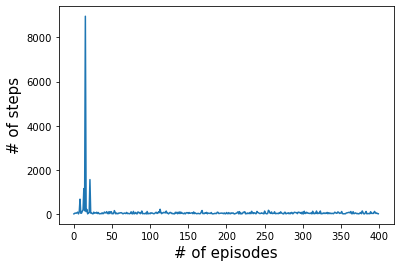

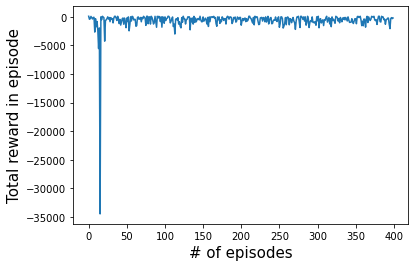

In [195]:
N = 4
M = 3
lr = 0.06
gamma = 0.99
epsilon = 0.10
k = 0.2
rews = []

# envt = makeEnvt(M, N)
np.savetxt('env.csv', envt, delimiter = ',')
print(np.reshape(envt, (N, N)), "\n")
rewards = []
for u in range(1):
    psi = np.ma.ones((N**2, 4))
    Q = np.ma.zeros((N**2, 4))
    for i in range(N**2):
        if i%N == 0:                       # move left
            psi[i,3] = np.ma.masked
            Q[i,3] = np.ma.masked
        if (i+1)%N == 0:                   # move right
            psi[i,1] = np.ma.masked
            Q[i,1] = np.ma.masked
        if i < N:                          # move up
            psi[i,0] = np.ma.masked
            Q[i,0] = np.ma.masked
        if i >= N*(N-1):                   # move down
            psi[i,2] = np.ma.masked  
            Q[i,2] = np.ma.masked
            
#     Q[2,1] = np.ma.masked
#     Q[8,2] = np.ma.masked 
#     Q[9,2] = np.ma.masked 
#     Q[7,0] = np.ma.masked 
#     Q[14,3] = np.ma.masked 
#     psi[14,3] = np.ma.masked
#     psi[7,0] = np.ma.masked
#     psi[2,1] = np.ma.masked
#     psi[8,2] = np.ma.masked 
#     psi[9,2] = np.ma.masked 
        
    for i in range(N**2):
        inds = psi[i]!= np.ma.masked 
        normalize = np.sqrt(psi[i,inds].shape)
        psi[i,:] = psi[i,:]/normalize            
            
    rews = []
    steps = []
    grovers = []
    episodes = 400
    V = np.zeros(N**2)
    
    for t in range(episodes):
#         print(u,t)
#         Q_copy = np.
        psi, Q, rew, step, grover = play(psi, Q, V, envt, lr, gamma, epsilon, N, k, 0)
        steps.append(step)
        grovers.append(grover)
        rews.append(rew)
    rewards.append(rews)

rewards = np.array(rewards)
rewards = np.mean(rewards, 0)
plt.plot(range(episodes), steps)
plt.xlabel('# of episodes', fontsize = 15)
plt.ylabel('# of steps', fontsize = 15)

plt.figure()
plt.plot(rewards)
plt.xlabel('# of episodes', fontsize = 15)
plt.ylabel('Total reward in episode', fontsize = 15)

plt.show()

In [196]:
psi

masked_array(
  data=[[--, 0.7071067811865475, 0.7071067811865475, --],
        [--, -0.1759030085313884, 0.13781227558570874,
         0.9747132441326003],
        [--, 0.7752589893489896, 0.504765706593084, 0.37971710638470557],
        [--, --, -0.7071067811865475, 0.7071067811865475],
        [-0.03081973214028788, -0.8285774231682279, -0.5590255789556571,
         --],
        [0.5, 0.5, -0.5, 0.5],
        [0.0, 1.0, 0.0, 0.0],
        [-0.8940068078581227, --, -0.07995316862369184,
         0.4408620173368989],
        [0.9441070697867388, -0.06165506357636941, -0.32382170080785744,
         --],
        [-0.5, 0.5, -0.5, -0.5],
        [-0.5, -0.5, 0.5, -0.5],
        [0.15725589972851284, --, -0.11921126914020397,
         0.9803362970483935],
        [0.7071067811865475, 0.7071067811865475, --, --],
        [0.9691158066054918, -0.2306905587029081, --,
         -0.08715744094869804],
        [-0.921408052672411, -0.03820305277955749, --,
         -0.3867140121960394],
       

In [139]:
print(np.reshape(envt, (N, N)), "\n")

[[   0.    0.    0.    0.]
 [   0.    0.    0. -100.]
 [   0.    0. -100.    0.]
 [   0. -100.    0.  100.]] 



In [173]:
psi

masked_array(
  data=[[--, 0.7071067811865475, 0.7071067811865475, --],
        [--, 0.2212077869255311, -0.4992488107062887, 0.8377456296584691],
        [--, 0.6408900213152922, -0.5097225168700268, 0.5739711982096054],
        [--, --, -0.7071067811865475, 0.7071067811865475],
        [-0.3364663710310849, 0.9045625903735575, -0.26183372827397866,
         --],
        [0.0, 0.0, 1.0, 0.0],
        [-0.5, -0.5, -0.5, -0.5],
        [0.15163443146265732, --, -0.322647406564296, 0.9342941989717878],
        [-0.15928094321484, -0.9704867702756854, 0.18106631340053148, --],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, -1.0],
        [-0.9080462430782253, --, -0.3216205136861974,
         0.26835101193724753],
        [0.7071067811865475, 0.7071067811865475, --, --],
        [0.14747526414803147, -0.8523732029898665, --,
         -0.5017080518481447],
        [0.7875862244294698, -0.2344514872639274, --, 0.5698600172048086],
        [0.7071067811865475, --, --, 0.70710678118654

In [177]:
steps[-5:]

[50, 38, 52, 38, 28]

In [89]:
Q_copy[N**2 - N - 1]

masked_array(data=[43.03501239454975, --, 98.99999956509171,
                   13.403770211079285],
             mask=[False,  True, False, False],
       fill_value=1e+20)

In [116]:
steps[-5:]

[150, 128, 806, 48, 320]

In [109]:
Q[1]

masked_array(data=[--, 0.3333333333333333, 0.3333333333333333,
                   0.3333333333333333],
             mask=[ True, False, False, False],
       fill_value=1e+20)

In [170]:
Q = np.ma.ones((N**2, 4))
for i in range(N**2):
    if i%N == 0:                       # move left
        Q[i,3] = np.ma.masked
    if (i+1)%N == 0:                   # move right
        Q[i,1] = np.ma.masked
    if i < N:                          # move up
        Q[i,0] = np.ma.masked
    if i >= N*(N-1):                   # move down
        Q[i,2] = np.ma.masked        

for i in range(N**2):
    inds = Q[i]!= np.ma.masked 
    normalize = np.sqrt(Q[i,inds].shape)
    Q[i,:] = Q[i,:]/normalize            

In [169]:
for i in range(-2):
    Q = grover_iteration(Q, 7)
print(Q[7])

[0.9891776216980012 -- -0.10374881380499468 -0.10374881380499468]


In [168]:
np.sum(Q[7]**2)

1.0000000000000009

In [179]:
for i in range(-4):
    print("hello")
    print(i)